In [1]:
from IPython.core.debugger import Tracer

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import argparse
from datetime import datetime
import os
import time
import multiprocessing
import psutil
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import h5py
from sklearn.model_selection import train_test_split
from skimage.util import crop,  random_noise
from skimage.transform import   rescale, resize, rotate, AffineTransform, warp
import torch.optim as optim
from tqdm import tqdm

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
num_epochs = 10

this limitation is particular to the current implementation and essentially because intermediate activations for both baselines and inputs need to be stored in the forward pass and used to override the gradient in the backward pass. Currently, those activations are stored as (temporary) attributes on the corresponding modules themselves, so a reused activation causes overwriting the stored temporary attributes. (A similar issue also indirectly affects layer and neuron attribution methods in Captum, they always attribute with respect to the last execution of a reused module.)

In most cases, we may be able to get around this issue with refactoring the implementation to allow storing multiple activations for a single module by keying on the execution count, essentially by separately storing the activations for the 1st, 2nd, 3rd, etc. time the module is executed. We haven't yet worked on this refactor, but we will consider if we can prioritize it for future releases if this is a common issue.

In [4]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

        # Added another relu here
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        # Modified to use relu2
        out = self.relu2(out)

        return out

In [5]:
h5_file = "data/Lyse fix sample_1_Focused & Singlets & CD45 pos.h5"

In [6]:
def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

In [7]:
def train_validation_test_split(h5_file, validation_size = 0.15, test_size = 0.20):
    data = h5py.File(h5_file, "r")
    object_numbers = data.get("object_number")[()]
    data.close()
    train, test = train_test_split( range(len(object_numbers)),
                                       test_size=test_size, 
                                       random_state=314)
    train, validation = train_test_split( train,
                                       test_size=validation_size, 
                                       random_state=314)
    return train, validation, test

In [8]:
def get_classes_map(h5_file):
    data = h5py.File(h5_file, "r")
    label_map = data.get("label_map")[()]
    data.close() 
    return eval(label_map)

label_map = get_classes_map(h5_file)

In [9]:
def number_of_channels(h5_file):
    data = h5py.File(h5_file, "r")
    object_numbers = data.get("object_number")[()]
    o_n = object_numbers[0]
    num_channels = data.get(str(o_n)  + "_image"  )[()].shape[2]
    data.close() 
    return num_channels

In [10]:
def number_of_classes(h5_file):
    data = h5py.File(h5_file, "r")
    labels = data.get("labels")[()] 
    num_classes = len(set(labels))
    data.close() 
    return num_classes

In [40]:
class Dataset_Generator(Dataset):

    def __init__(self,  h5_file , set_indx , scaling_factor = 4095. , 
                    reshape_size = 64, data_map = [], statistics = None , transform=None, means = None, stds = None):

        self.data =  h5py.File(h5_file, "r") 

        object_numbers = self.data.get("object_number")[()]
            
        try:
            labels = self.data.get("labels")[()]
        except TypeError as TE:
            labels =np.array( len(indx)*[-1])
        
        
        self.object_numbers = object_numbers[set_indx]
        self.labels = labels[set_indx]
        
        self.num_channels = number_of_channels(h5_file)
        self.scaling_factor = scaling_factor
        self.reshape_size = reshape_size 
        self.data_map = data_map
        self.statistics = statistics  
        self.transform = transform
        if means is None: 
            self.means = torch.zeros(self.num_channels)
        else:
            self.means = means
        if stds is None: 
            self.stds = torch.ones(self.num_channels)
        else:
            self.stds = stds
        
    def __len__(self):
        return len(self.object_numbers)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist() 
        
        o_n = self.object_numbers[idx]
        lbl = self.labels[idx]
        
        try:
            image_original = self.data.get(str(o_n) + "_image")[()]  / self.scaling_factor
            #image_original = (image_original - self.means) / self.stds 
            # creating the image
            h, w = crop_pad_h_w(image_original, self.reshape_size)
            h1_crop, h2_crop, h1_pad, h2_pad =  h 
            w1_crop, w2_crop, w1_pad, w2_pad = w 
            image = np.zeros((self.num_channels , self.reshape_size, self.reshape_size), dtype = np.float64)

            # filling the image with different channels 
            for ch in range(image_original.shape[2]): 
                image_dummy = crop(image_original[:,:,ch], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
                image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), "edge" )
                image[ch,:,:] = image_dummy


            image_original = None

            # map numpy array to tensor
            image = torch.from_numpy(image.copy())
            for i in range(self.num_channels):
                image[i] = (image[i] - self.means[i]) / self.stds[i]

            if self.transform:
                image = self.transform(image)

            label = np.array([lbl]) 
            
            object_number = np.array([o_n])  
            
            sample = {'image': image ,'label': torch.from_numpy(label) , "idx":idx, "object_number" : object_number }
        except:
            sample = {'image': torch.from_numpy( np.zeros((12, self.reshape_size, self.reshape_size), dtype = np.float64) ),  
                      'label': torch.from_numpy(np.array([-1])) , "idx":idx, "object_number" : np.array([-1]) }

        
        return sample



In [28]:
data = h5py.File(h5_file, "r") 
image_original = data.get(str(21043) + "_image")[()]
h, w = crop_pad_h_w(image_original, 64)
h1_crop, h2_crop, h1_pad, h2_pad =  h 
w1_crop, w2_crop, w1_pad, w2_pad = w 
image = np.zeros((12 , 64, 64), dtype = np.float64)
for ch in range(image_original.shape[2]): 
        image_dummy = crop(image_original[:,:,ch], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), "edge" )
        image[ch,:,:] = image_dummy
image = torch.from_numpy(image.copy())

In [32]:
image_original.shape

(73, 50, 12)

In [34]:
train_indx, validation_indx, test_indx = train_validation_test_split(h5_file)

In [35]:
transform = transforms.Compose(
    [transforms.RandomVerticalFlip(),
     transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45)])


train_dataset =  Dataset_Generator(h5_file , train_indx, reshape_size = 64, transform=transform) 
validation_dataset =  Dataset_Generator(h5_file , validation_indx, reshape_size = 64 )
test_dataset =  Dataset_Generator(h5_file , test_indx, reshape_size = 64 )


In [36]:
trainloader = DataLoader( train_dataset, 
                                batch_size= batch_size, 
                                shuffle=False, 
                                num_workers=2)
validationloader = DataLoader( validation_dataset, 
                                batch_size= batch_size, 
                                shuffle=False, 
                                num_workers=1)
testloader = DataLoader( test_dataset, 
                                batch_size= batch_size, 
                                shuffle=False, 
                                num_workers=1)

3


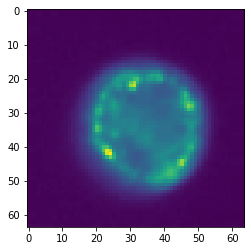

In [37]:
print(test_dataset[0]["label"].numpy()[0])
plt.imshow(test_dataset[0]["image"][1,:,:])

In [ ]:
#images = torch.empty(0, dtype=torch.float32, device=device)
mean_per_channel = []
stds_per_channel = []
for data in trainloader:
    indx = (data["object_number"] != -1).reshape(-1)
    if indx.sum() > 0:
        inputs = data["image"][indx]
        inputs = inputs.to(device)
        inputs = inputs.float()
        #inputs = images.view(inputs.shape[0], images.size(2),images.size(1), -1)
        #batch_size = inputs.shape[0]
        #Tracer()()
        mean_per_channel.append(inputs.mean(dim=(2,3)).sum(0))
        stds_per_channel.append(inputs.std(dim=(2,3)).sum(0))
means = torch.sum(torch.stack(mean_per_channel, axis=0), dim=0) / len(train_dataset)
stds = torch.sum(torch.stack(stds_per_channel, axis=0), dim=0) / len(train_dataset)

In [ ]:
numer_of_channels = 12    

statistics = dict()
#statistics["min"] = torch.zeros(numer_of_channels) + np.power(2,16) # 16-bit images
statistics["mean"] = torch.zeros(numer_of_channels)
statistics["std"] = torch.zeros(numer_of_channels)
#statistics["max"] = torch.zeros(numer_of_channels)


for j, data in enumerate(trainloader, 1): 

    data = data["image"] 
    for i in range(numer_of_channels):
        #statistics["min"][i] = min(data[:,i,:,:].min(), statistics["min"][i])
        statistics["mean"][i] += data[:,i,:,:].mean()
        statistics["std"][i] += data[:,i,:,:].std()
        #statistics["max"][i] = max(data[:,i,:,:].max(), statistics["max"][i])
train_dataset =  Dataset_Generator(h5_file , train_indx, reshape_size = 64, transform=transform, means=statistics["mean"].div_(len(trainloader)), stds=statistics["std"].div_(len(trainloader))) 

In [48]:
statistics_val = dict()
#statistics["min"] = torch.zeros(numer_of_channels) + np.power(2,16) # 16-bit images
statistics_val["mean"] = torch.zeros(numer_of_channels)
statistics_val["std"] = torch.zeros(numer_of_channels)
#statistics["max"] = torch.zeros(numer_of_channels)


for j, data in enumerate(validationloader, 1): 

    data = data["image"] 
    for i in range(numer_of_channels):
        #statistics["min"][i] = min(data[:,i,:,:].min(), statistics["min"][i])
        statistics_val["mean"][i] += data[:,i,:,:].mean()
        statistics_val["std"][i] += data[:,i,:,:].std()
        #statistics["max"][i] = max(data[:,i,:,:].max(), statistics["max"][i])
validation_dataset =  Dataset_Generator(h5_file , validation_indx, reshape_size = 64, means=statistics_val["mean"].div_(len(validationloader)), stds=statistics_val["std"].div_(len(validationloader)) )

3


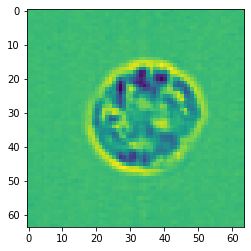

In [50]:
print(validation_dataset[2]["label"].numpy()[0] )
plt.imshow(validation_dataset[2]["image"][0,:,:])

In [51]:
trainloader = DataLoader( train_dataset, 
                                batch_size= batch_size, 
                                shuffle=False, 
                                num_workers=2)
validationloader = DataLoader( validation_dataset, 
                                batch_size= batch_size, 
                                shuffle=False, 
                                num_workers=1)

In [52]:
label_map

{0: ' unknown',
 1: ' CD4+ T',
 2: ' CD8+ T',
 3: ' CD15+ neutrophil',
 4: ' CD14+ monocyte',
 5: ' CD19+ B',
 6: ' CD56+ NK',
 7: ' NKT',
 8: ' eosinophil'}

In [53]:
num_classes = number_of_classes(h5_file)
num_channels = number_of_channels(h5_file)

In [54]:
model = resnet18(pretrained=True)
## loading the imagenet weights in case it is possible
if num_channels != 3:
    model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(7, 7), 
                            stride=(2, 2), padding=(3, 3), bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
model = model.to(device)

In [55]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [56]:
num_epochs = 10
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    print("epoch", epoch)
    for i, data in enumerate(trainloader, 0): 
        
        # get the inputs; data is a list of [inputs, labels]
        indx = (data["object_number"] != -1).reshape(-1)
        if indx.sum() > 0:
            inputs, labels = data["image"][indx], data["label"][indx]

            inputs, labels = inputs.to(device), labels.to(device)     
            inputs = inputs.float()
            labels = labels.reshape(-1)


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs) 
            _ , predicted = torch.max(outputs.data, 1) 


            loss = criterion(outputs, F.one_hot(labels.long(), num_classes ).type_as(outputs))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print('[%d, %5d] training loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            indx = (data["object_number"] != -1).reshape(-1)
            if indx.sum() > 0:
                inputs, labels = data["image"][indx], data["label"][indx]

                inputs, labels = inputs.to(device), labels.to(device)     
                inputs = inputs.float()
                labels = labels.reshape(-1)

                outputs = model(inputs)
                _ , predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (labels.reshape(-1) == predicted).sum().item()

    print('Accuracy of the network on the %d validation images: %d %%' % (len(validation_dataset), 100 * correct / total))#
        
print('Finished Training')

epoch 0
Accuracy of the network on the 3754 validation images: 83 %
epoch 1
Accuracy of the network on the 3754 validation images: 89 %
epoch 2
Accuracy of the network on the 3754 validation images: 91 %
epoch 3
Accuracy of the network on the 3754 validation images: 92 %
epoch 4
Accuracy of the network on the 3754 validation images: 93 %
epoch 5
Accuracy of the network on the 3754 validation images: 93 %
epoch 6
Accuracy of the network on the 3754 validation images: 94 %
epoch 7
Accuracy of the network on the 3754 validation images: 94 %
epoch 8
Accuracy of the network on the 3754 validation images: 94 %
epoch 9
Accuracy of the network on the 3754 validation images: 94 %
Finished Training


In [57]:
statistics_test = dict()
#statistics["min"] = torch.zeros(numer_of_channels) + np.power(2,16) # 16-bit images
statistics_test["mean"] = torch.zeros(numer_of_channels)
statistics_test["std"] = torch.zeros(numer_of_channels)
#statistics["max"] = torch.zeros(numer_of_channels)


for j, data in enumerate(testloader, 1): 

    data = data["image"] 
    for i in range(numer_of_channels):
        #statistics["min"][i] = min(data[:,i,:,:].min(), statistics["min"][i])
        statistics_test["mean"][i] += data[:,i,:,:].mean()
        statistics_test["std"][i] += data[:,i,:,:].std()
        #statistics["max"][i] = max(data[:,i,:,:].max(), statistics["max"][i])
test_dataset =  Dataset_Generator(h5_file , validation_indx, reshape_size = 64, means=statistics_test["mean"].div_(len(testloader)), stds=statistics_test["std"].div_(len(testloader)) )
testloader = DataLoader( test_dataset, 
                                batch_size= batch_size, 
                                shuffle=False, 
                                num_workers=1)

In [58]:
correct = 0.
total = 0.

with torch.no_grad():
    for data in testloader:
        indx = (data["object_number"] != -1).reshape(-1)
        if indx.sum() > 0:
            inputs, labels = data["image"][indx], data["label"][indx]

            inputs, labels = inputs.to(device), labels.to(device)     
            inputs = inputs.float()
            labels = labels.reshape(-1)

            outputs = model(inputs)
            _ , predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (labels.reshape(-1) == predicted).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (len(test_dataset),
    100 * correct / total))

Accuracy of the network on the 3754 test images: 94 %


In [60]:
torch.save(model.state_dict(), "models/final_model_normalized_state_dict.pth")

In [61]:
model = resnet18(pretrained=True)
## loading the imagenet weights in case it is possible
if num_channels != 3:
    model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(7, 7), 
                            stride=(2, 2), padding=(3, 3), bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
model = model.to(device)
model.load_state_dict(torch.load('models/final_model_normalized_state_dict.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [62]:
from captum.attr import GuidedGradCam, DeepLift, Saliency, DeepLiftShap, GradientShap, InputXGradient, GuidedBackprop, GuidedGradCam, Deconvolution

In [63]:
from collections.abc import Sequence
from functools import partial
from typing import Optional, Union

import numpy as np
import torch
import torch.nn as nn

softmax = nn.Softmax(dim=1)

try:
    from tqdm import trange

    trange = partial(trange, desc="Computing occlusion sensitivity")
except (ImportError, AttributeError):
    trange = range
    

def _append_to_sensitivity_im(model, batch_images, batch_ids, sensitivity_im):
    """For given number of images, get probability of predicting
    a given label. Append to previous evaluations."""
    batch_images = torch.cat(batch_images, dim=0)
    batch_ids = torch.LongTensor(batch_ids).unsqueeze(1).to(sensitivity_im.device)
    scores = model(batch_images).detach().gather(1, batch_ids)
    #Tracer()()
    return torch.cat((sensitivity_im, scores))

def compute_occlusion_sensitivity_debug_per_channel_custom(
    model: nn.Module,
    image: torch.Tensor,
    label: Union[int, torch.Tensor],
    pad_val: float = 0.0,
    margin: Union[int, Sequence] = 2,
    n_batch: int = 128,
    stride: Union[int, Sequence] = 1,
    upsample_mode: str = "nearest",
    threshold: float = 0.0
) -> np.ndarray:

    im_shape = np.array(image.shape[1:])

    # Get baseline probability
    baseline = model(image).detach()[0, label].item()
    
    #image = image.T

    # Create some lists
    batch_images = []
    batch_ids = []

    sensitivity_im = torch.empty(0, dtype=torch.float32, device=image.device)
    
    # If no bounding box supplied, output shape is same as input shape.
    # If bounding box is present, shape is max - min + 1
    output_im_shape = im_shape

    # Calculate the downsampled shape
    if not isinstance(stride, Sequence):
        stride_np = np.full_like(im_shape, stride, dtype=np.int32)
        stride_np[0] = 1  # always do stride 1 in channel dimension
    else:
        # Convert to numpy array and check dimensions match
        stride_np = np.array(stride, dtype=np.int32)
        if stride_np.size != im_shape.size:
            raise ValueError("Sizes of image shape and stride should match.")

    # Obviously if stride = 1, downsampled_im_shape == output_im_shape
    downsampled_im_shape = np.floor(output_im_shape / stride_np).astype(np.int32)
    downsampled_im_shape[downsampled_im_shape == 0] = 1  # make sure dimension sizes are >= 1
    num_required_predictions = np.prod(downsampled_im_shape)
    
    for layer in range(12):
        for i in trange(int(num_required_predictions / 12)):
            channel = image[0][layer].clone()
            #Tracer()()
            stride_np = np.full_like(channel.shape, stride, dtype=np.int32)
            stride_np[0] = 1
            #C
            # Get corresponding ND index
            idx = np.unravel_index(i, downsampled_im_shape[1:])
    
            # Multiply by stride
            idx *= stride_np
                
            # Get min and max index of box to occlude
            min_idx = [max(0, i - margin) for i in idx]
            max_idx = [min(j, i + margin) for i, j in zip(idx, channel.shape)]
            #Tracer()()

            # Clone and replace target area with `pad_val`
            occlu_im = image.clone()
            #Tracer()()
            channel[min_idx[0]:max_idx[0],min_idx[1]:max_idx[1]] = pad_val
            #channel[(...,) + tuple(slice(i, j) for i, j in zip(min_idx, max_idx))] = pad_val
            occlu_im[0][layer] = channel
            #plt.imshow(occlu_im[0].T)
            #Tracer()()

            # Add to list
            #batch_images.append(occlu_im.T)
            batch_images.append(occlu_im)
            batch_ids.append(label)
            if len(batch_images) == n_batch or i == int(num_required_predictions / 12) - 1:
            # Do the predictions and append to sensitivity map
                sensitivity_im = _append_to_sensitivity_im(model, batch_images, batch_ids, sensitivity_im)
                # Clear lists
                #Tracer()()
                batch_images = []
                batch_ids = []
    #Tracer()()
    # Subtract from baseline
    sensitivity_im = baseline - sensitivity_im

    # Reshape to match downsampled image
    sensitivity_im = np.where(sensitivity_im<threshold, 0, sensitivity_im)
    #Tracer()()
    sensitivity_im = sensitivity_im.reshape(tuple(downsampled_im_shape))

    # If necessary, upsample
    if np.any(stride_np != 1):
        output_im_shape = tuple(output_im_shape[1:])  # needs to be given as 3D tuple
        upsampler = nn.Upsample(size=output_im_shape, mode=upsample_mode)
        sensitivity_im = upsampler(sensitivity_im.unsqueeze(0))

    # Convert tensor to numpy
    #sensitivity_im = sensitivity_im.cpu().numpy()
    #sensitivity_im = (sensitivity_im - np.min(sensitivity_im)) / (np.max(sensitivity_im) - np.min(sensitivity_im))
    #Tracer()()
    # Squeeze and return
    return np.squeeze(sensitivity_im)

In [64]:
def plot_heatmap_12_channels(heatmap):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(15,15))
    #plt.figure(figsize=(20,10))
    ax1.imshow(heatmap[0])
    ax2.imshow(heatmap[1])
    ax3.imshow(heatmap[2])

    ax4.imshow(heatmap[3])
    ax5.imshow(heatmap[4])
    ax6.imshow(heatmap[5])

    ax7.imshow(heatmap[6])
    ax8.imshow(heatmap[7])
    ax9.imshow(heatmap[8])

    ax10.imshow(heatmap[9])
    ax11.imshow(heatmap[10])
    ax12.imshow(heatmap[11])

In [65]:
def plot_heatmap_12_channels_hist(heatmap):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(15,15))
    #plt.figure(figsize=(20,10))
    ax1.hist(heatmap[0].ravel(), bins = 50)
    ax2.hist(heatmap[1].ravel(), bins = 50)
    ax3.hist(heatmap[2].ravel(), bins = 50)

    ax4.hist(heatmap[3].ravel(), bins = 50)
    ax5.hist(heatmap[4].ravel(), bins = 50)
    ax6.hist(heatmap[5].ravel(), bins = 50)

    ax7.hist(heatmap[6].ravel(), bins = 50)
    ax8.hist(heatmap[7].ravel(), bins = 50)
    ax9.hist(heatmap[8].ravel(), bins = 50)

    ax10.hist(heatmap[9].ravel(), bins = 50)
    ax11.hist(heatmap[10].ravel(), bins = 50)
    ax12.hist(heatmap[11].ravel(), bins = 50)

In [66]:
occlusion_custom = compute_occlusion_sensitivity_debug_per_channel_custom(model, test_dataset[2]["image"].reshape((1,12,64,64)).float(), test_dataset[2]["label"].numpy()[0], margin=4, threshold=6.21183)

Computing occlusion sensitivity: 100%|██████████| 4096/4096 [00:08<00:00, 466.63it/s]


In [67]:
(occlusion_custom.max() - occlusion_custom.min()) /2

4.866371154785156

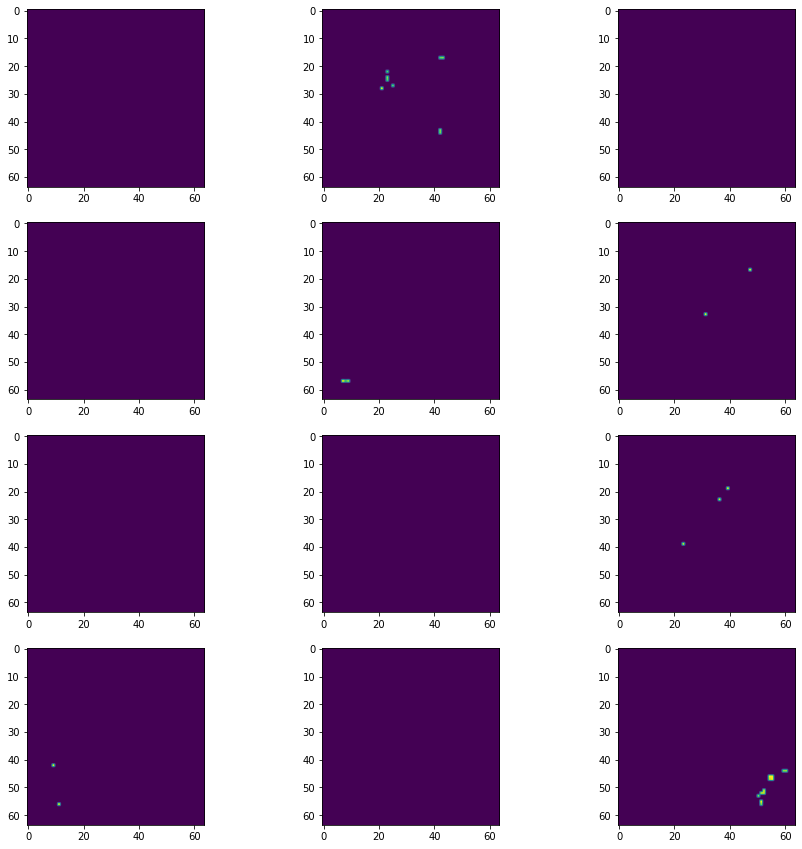

In [68]:
plot_heatmap_12_channels(occlusion_custom)

In [69]:
dl = DeepLift(model)
attribution_dl = dl.attribute(test_dataset[2]["image"].reshape((1,12,64,64)).float(), target=int(test_dataset[2]["label"].numpy()[0]))

/home/aleksandra/PycharmProjects/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/aleksandra/PycharmProjects/captum/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


In [70]:
attribution_dl.min()

tensor(-0.0429, grad_fn=<MinBackward1>)

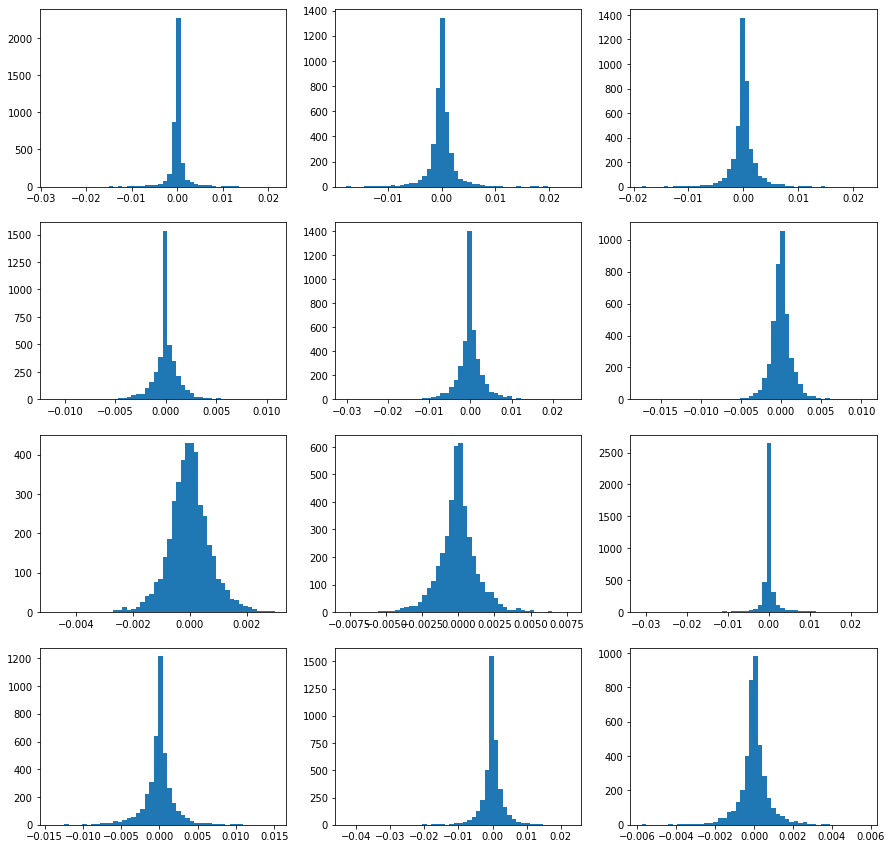

In [71]:
plot_heatmap_12_channels_hist(attribution_dl.detach().numpy()[0])

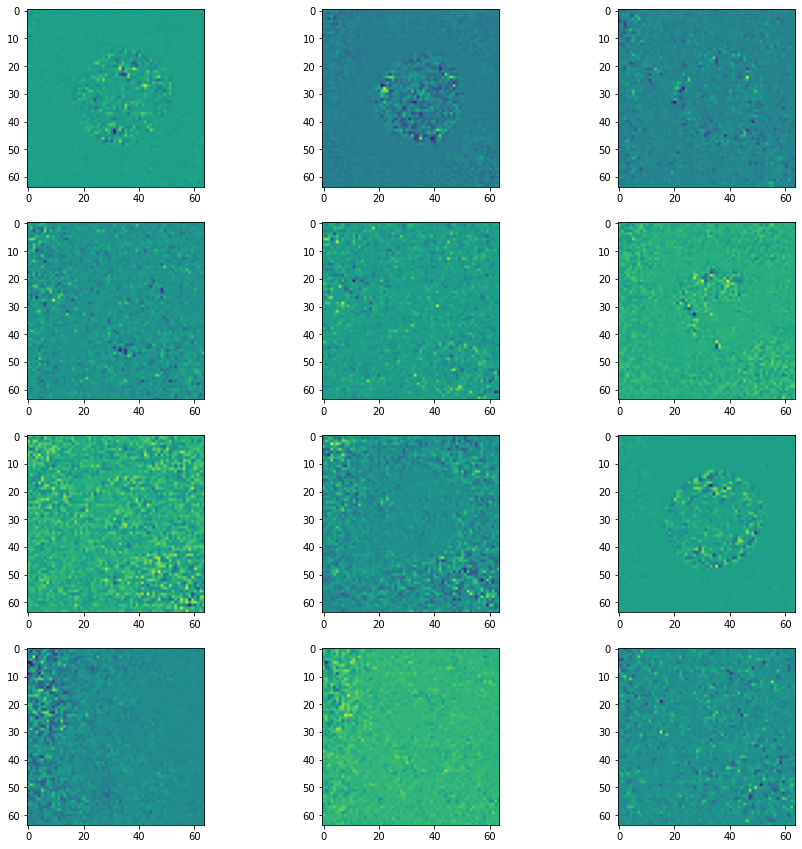

In [72]:
plot_heatmap_12_channels(attribution_dl.detach().numpy()[0])

In [73]:
deepLift_threshold = torch.where(attribution_dl > torch.Tensor([0.02]), attribution_dl, torch.Tensor([0]))

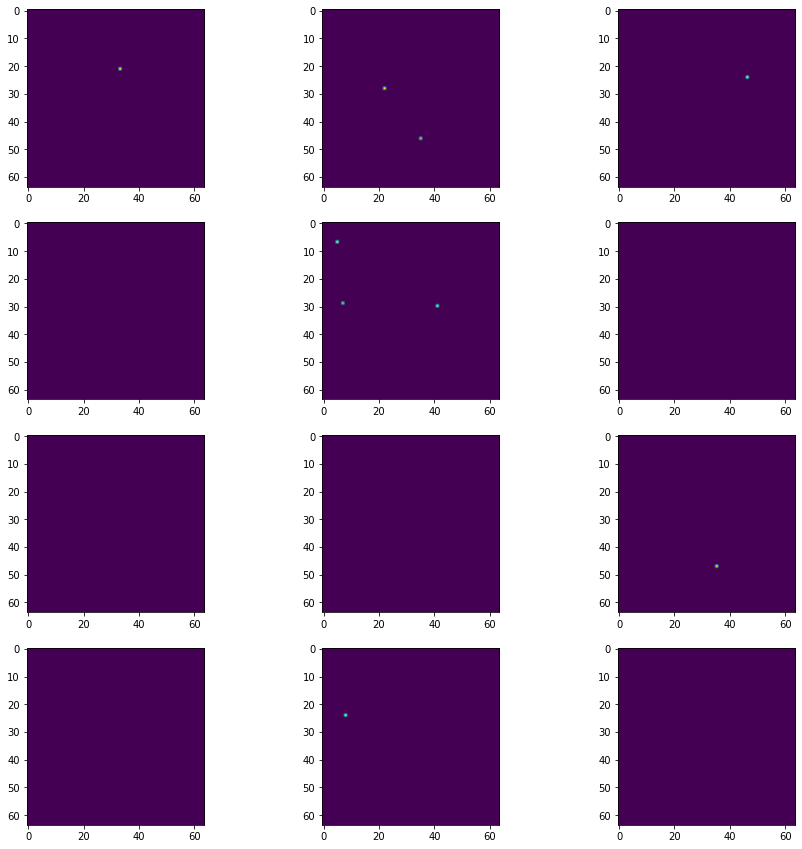

In [74]:
plot_heatmap_12_channels(deepLift_threshold.detach().numpy()[0])

In [ ]:
import copy
import random
def pixel_permutation_per_channel(
    model: nn.Module,
    image: torch.Tensor,
    label: Union[int, torch.Tensor],
) -> np.ndarray:

    # Get baseline probability
    baseline = model(image).detach()[0, label].item()
    im_shape = np.array(image.shape[1:])
    res = []
    im_stack = []
    for i in range(im_shape[0]):
        im = copy.deepcopy(image)
        channel_shape = im[0][i].shape
        arr = copy.deepcopy(im[0][i].flatten().detach())
        random.shuffle(arr)
        #np.random.shuffle(arr)
        im[0][i] = arr.reshape(channel_shape)
        softmax = nn.Softmax(dim=1)
        prob = softmax(model(im)).detach()[0, label].item()
        res.append({"chanel": i, "prob": prob})
        im_stack.append(im[0][i])
        #Tracer()()
    #Tracer()()
    im_stack = np.stack(im_stack, axis=0)
    plot_heatmap_12_channels(im_stack)
    return res

In [ ]:
pixel_permutation_per_channel(model, test_dataset[2]["image"].reshape((1,12,64,64)).float(), test_dataset[2]["label"].numpy()[0])

In [ ]:
plot_heatmap_12_channels(test_dataset[2]["image"])

In [ ]:
with torch.no_grad():
    heatmaps = torch.empty(0, dtype=torch.float32, device=device)
    for data in testloader:
        indx = (data["object_number"] != -1).reshape(-1)
        if indx.sum() > 0:
            inputs, labels = data["image"][indx], data["label"][indx]

            inputs, labels = inputs.to(device), labels.to(device)     
            inputs = inputs.float()
            labels = labels.reshape(-1)
            for (i,l) in zip(inputs, labels):
                heatmap = dl.attribute(i.reshape((1,12,64,64)).float(), target=l)
                #Tracer()()
                heatmaps = torch.cat((heatmaps, heatmap))

In [ ]:
heatmaps.shape

In [ ]:
with torch.no_grad():
    heatmaps = torch.empty(0, dtype=torch.float32, device=device)
    for data in testloader:
        indx = (data["object_number"] != -1).reshape(-1)
        if indx.sum() > 0:
            inputs, labels = data["image"][indx], data["label"][indx]

            inputs, labels = inputs.to(device), labels.to(device)     
            inputs = inputs.float()
            labels = labels.reshape(-1)
            for (i,l) in zip(inputs, labels):
                heatmap = dl.attribute(i.reshape((1,12,64,64)).float(), target=l)
                #Tracer()()
                heatmaps = torch.cat((heatmaps, heatmap))

In [ ]:
def calculate_aops(model, testloader, label, heatmaps, L = 10000):
    with torch.no_grad():
        for data in testloader:
            indx = (data["object_number"] != -1).reshape(-1)
            if indx.sum() > 0:
                inputs, labels = data["image"][indx], data["label"][indx]

                inputs, labels = inputs.to(device), labels.to(device)     
                inputs = inputs.float()
                labels = labels.reshape(-1)

                baseline = model(inputs)
                _ , predicted = torch.max(outputs.data, 1)


                shape = inputs.shape
                image_flatten = inputs.flatten()
                flatten_attr = heatmap.flatten()
    #Tracer()()
    o = flatten_attr.sort(descending=True)
    #o = flatten_attr[::-1].sort()
    indices = o[1]
    if len(indices)<L:
        length = len(indices)
    else: length = L
    interm_sum = 0
    res = []
    for i in range(length):
        copy_arr = image_flatten.clone()
        idx = indices[:i+1]
        for j in idx:
            copy_arr[j] = 0
        prob_occl = model(copy_arr.reshape(shape)).detach()[0, label].item()
        interm_sum += baseline - prob_occl
        res.append(interm_sum / (i+1))
        #Tracer()()
    plt.bar(range(1,len(res)+1), res)
    #softmax
    return interm_sum / (length+1)

In [ ]:
#model